In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from market_microstructure_toolkit.exchange import make_exchange
from market_microstructure_toolkit.record import record_snapshots
from market_microstructure_toolkit.metrics import compute_row_metrics

EXCHANGE = "bybit"
MARKETTYPE = "swap"
SYMBOL = "ETH/USDT:USDT"
DEPTH = 100
SECONDS = 50
HZ = 1.0
BOOK_LEVEL = "L2"
FORMAT = "parquet"  # "parquet" or "csv"
OUT_PATH = Path(f"data/{EXCHANGE}_{SYMBOL}_{MARKETTYPE}_{SECONDS}s.{FORMAT}")  # or .csv


Path("data").mkdir(exist_ok=True, parents=True)

In [3]:
ex = make_exchange(EXCHANGE, default_type=MARKETTYPE, timeout=10_000)
record_snapshots(
    ex=ex,
    symbol=SYMBOL,
    depth=DEPTH,
    seconds=SECONDS,
    hz=HZ,
    out_path=str(OUT_PATH),
    book_level=BOOK_LEVEL,
    out_format=FORMAT,
)
OUT_PATH

PosixPath('data/bybit_ETH/USDT:USDT_swap_50s.parquet')

In [4]:
df = pd.read_parquet(OUT_PATH)

# if it was csv
# df = pd.read_csv(OUT_PATH)
# convert numeric columns just in case
# for c in ["best_bid","best_ask"] + [f"{s}{i}_{t}" for s in ("bid","ask") for i in range(1, DEPTH+1) for t in ("price","size")]:
#    if c in df.columns:
#        df[c] = pd.to_numeric(df[c], errors="coerce")

In [5]:
def add_metrics(frame, depth):
    # apply row-wise: returns dict per row, expand into columns
    metrics = frame.apply(
        lambda r: compute_row_metrics(r.to_dict(), depth), axis=1, result_type="expand"
    )
    return frame.join(metrics)


dfm = add_metrics(df, DEPTH)
dfm.head()

,ts_ms,iso,exchange_id,symbol,book_level,raw_nonce,best_bid,best_ask,bid1_price,bid1_size,...,ask98_price,ask98_size,ask99_price,ask99_size,ask100_price,ask100_size,spread,mid,imbalance_l1,imbalance_k
0,1755427800974,2025-08-17T10:50:00.974000+00:00,bybit,ETH/USDT:USDT,L2,,4550.41,4550.42,4550.41,85.71,...,4552.01,21.73,4552.02,0.01,4552.03,0.88,0.01,4550.415,0.969460,0.560367
1,1755427801074,2025-08-17T10:50:01.074000+00:00,bybit,ETH/USDT:USDT,L2,,4550.41,4550.42,4550.41,0.56,...,4551.96,0.80,4551.98,2.22,4551.99,5.68,0.01,4550.415,0.006247,0.467612
2,1755427801174,2025-08-17T10:50:01.174000+00:00,bybit,ETH/USDT:USDT,L2,,4550.41,4550.42,4550.41,2.48,...,4551.92,0.04,4551.93,18.50,4551.96,0.80,0.01,4550.415,0.037839,0.493758
3,1755427802174,2025-08-17T10:50:02.174000+00:00,bybit,ETH/USDT:USDT,L2,,4550.68,4550.69,4550.68,0.41,...,4552.27,0.01,4552.28,0.51,4552.29,3.51,0.01,4550.685,0.008936,0.452438
4,1755427803174,2025-08-17T10:50:03.174000+00:00,bybit,ETH/USDT:USDT,L2,,4550.17,4550.18,4550.17,32.41,...,4551.94,10.74,4551.95,0.17,4551.96,0.80,0.01,4550.175,0.569796,0.538856


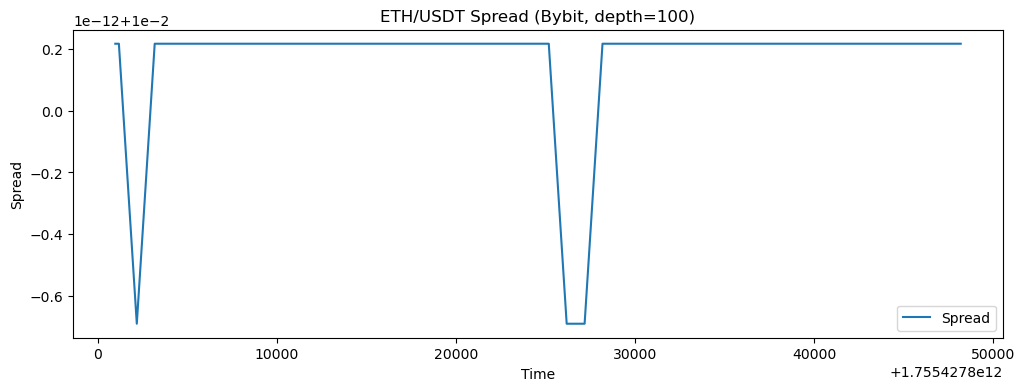

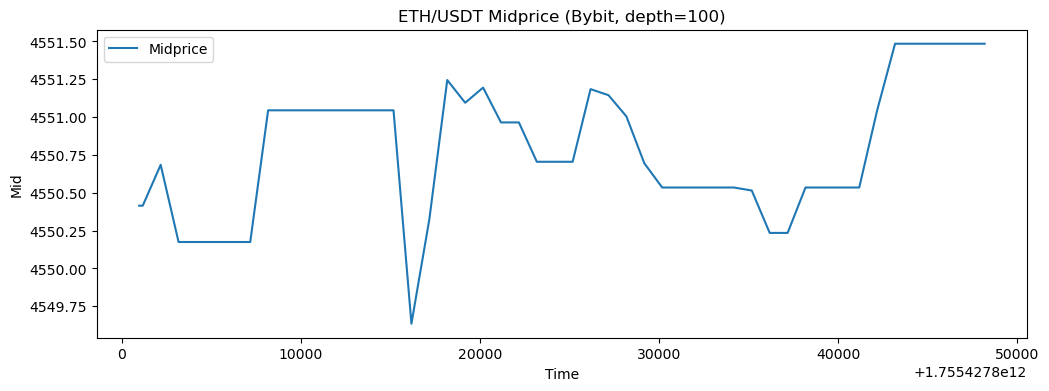

In [10]:

# Spread
plt.figure(figsize=(12, 4))
plt.plot(dfm["ts_ms"], dfm["spread"], label="Spread")
plt.xlabel("Time")
plt.ylabel("Spread")
plt.title("ETH/USDT Spread (Bybit, depth=100)")
plt.legend()
plt.show()

# Midprice
plt.figure(figsize=(12, 4))
plt.plot(dfm["ts_ms"], dfm["mid"], label="Midprice")
plt.xlabel("Time")
plt.ylabel("Mid")
plt.title("ETH/USDT Midprice (Bybit, depth=100)")
plt.legend()
plt.show()

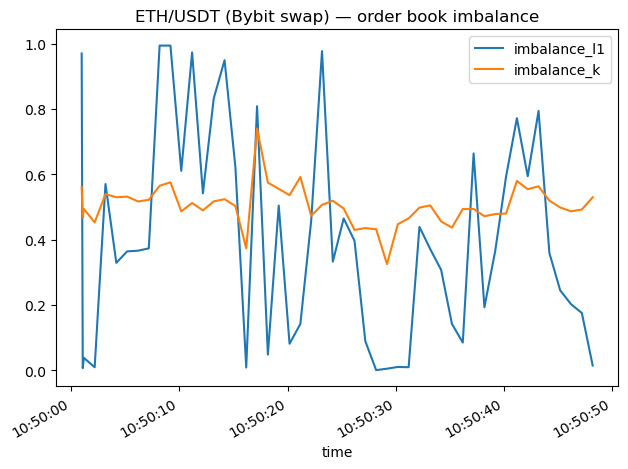

In [7]:
plt.figure()
cols = [c for c in ["imbalance_l1", "imbalance_k"] if c in dfm.columns]
if "iso" in dfm.columns:
    dfm.plot(x="iso", y=cols, ax=plt.gca())
else:
    dfm[cols].plot(ax=plt.gca())
plt.title("ETH/USDT (Bybit swap) — order book imbalance")
plt.xlabel("time")
plt.tight_layout()